In [1]:
# import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
import itertools

# read data from csv

In [2]:
INDEX_LIST = ['^GSPC', '^IXIC', '^DJI','^RUA']
# prices = yf.download(INDEX_LIST).dropna()['Adj Close']
# prices.to_csv(INDEX_DATA)

In [3]:
price = pd.read_csv("datafiles/index_prices.csv", index_col = 'Date').dropna() # .loc['2010-6-1':'2023-6-10']
price.index = pd.to_datetime(price.index) # convert from string to datetime format
price.head()

,^DJI,^GSPC,^IXIC,^RUA
Date,,,,
1992-01-02,3172.399902,417.260010,586.450012,232.289993
1992-01-03,3201.500000,419.339996,592.650024,235.580002
1992-01-06,3200.100098,417.959991,597.900024,235.350006
1992-01-07,3204.800049,417.399994,602.289978,235.369995
1992-01-08,3203.899902,418.100006,610.320007,236.119995


# plot the 4 price series

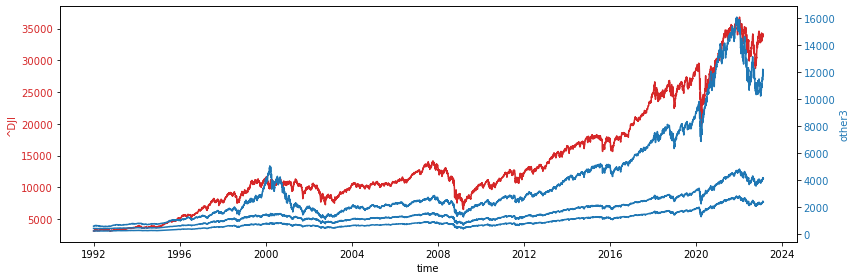

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 4))

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('^DJI', color=color)
ax1.plot(price['^DJI'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('other3', color=color)  # we already handled the x-label with ax1
ax2.plot(price[['^GSPC', '^IXIC', '^RUA']], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Compute the spreads
co-integration style spread, parameters updated on a rolling basis

In [5]:
"""def compute_trading_ratio(data):
    # compute the trading ratio using the recent 90 data
    model = sm.OLS(data.iloc[-90:, 0], data.iloc[-90:, 1])
    model = model.fit()
    return model.params[0]"""

def compute_trading_ratios(data):
    # compute trading_ratios by rolling OLS
    endog = data.iloc[:, 0]  # dependent variable Y
    exog = data.iloc[:, 1]  # independent variable X
    rols = RollingOLS(endog, exog, window=20)
    rres = rols.fit()
    trading_ratios = rres.params.copy()
    trading_ratios.columns = ['trading_ratio']
    return trading_ratios

In [6]:
def compute_spread(data, trading_ratios):
    df = pd.merge(data, trading_ratios, left_index=True, right_index=True)
    spread = data.iloc[:, 0] - df.trading_ratio * df.iloc[:, 1]
    return spread.dropna()

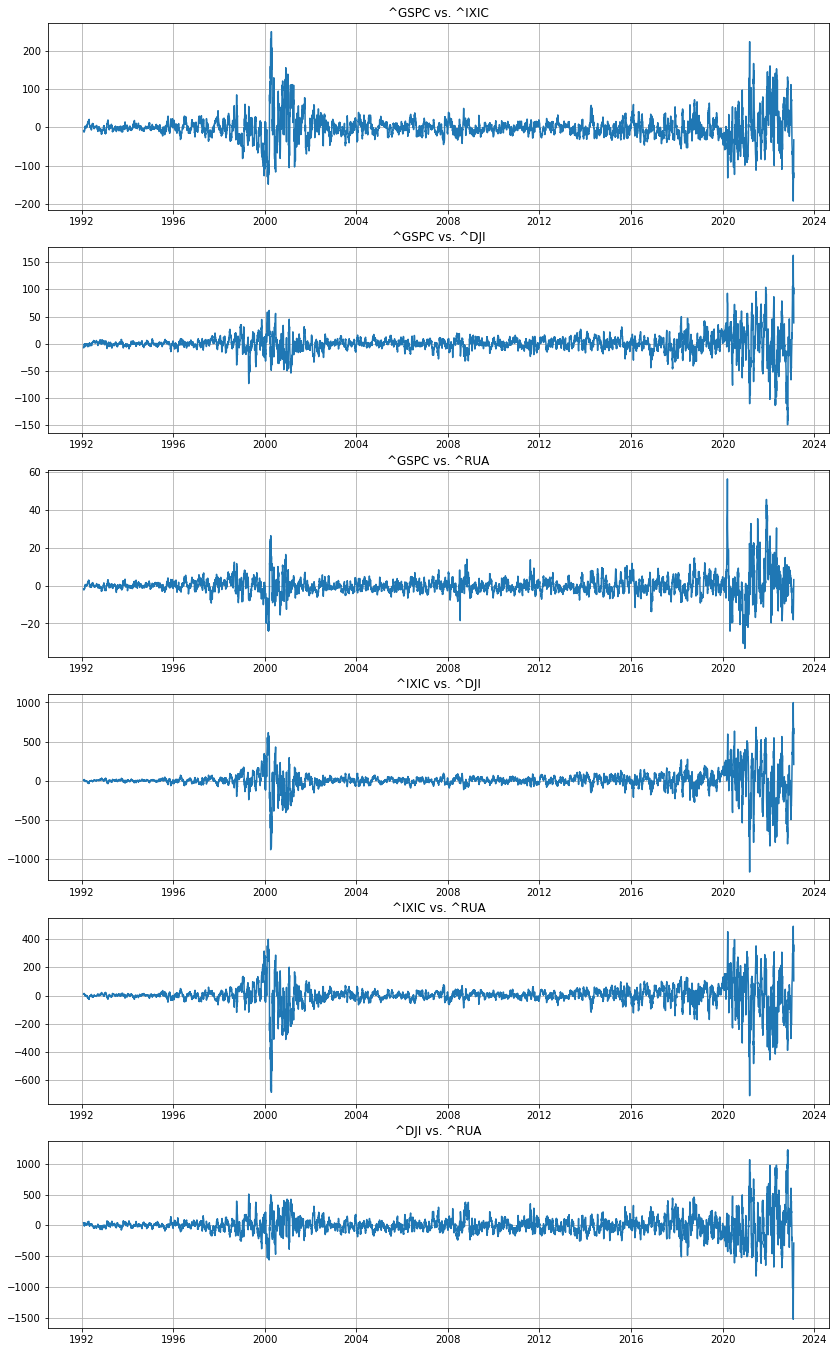

In [7]:
fig, axs = plt.subplots(6, 1, figsize=(14, 24))
ax_lst = [(i, 0) for i in range(6)]
i = 0

spread_lst = []
trading_ratios_lst = []
for idx0, idx1 in itertools.combinations(INDEX_LIST, 2):
    data = price[[idx0, idx1]]
    trading_ratios = compute_trading_ratios(data)
    trading_ratios_lst.append(trading_ratios)
    spread = compute_spread(data, trading_ratios.shift(1)) # shift by 1 to avoid look ahead bias
    spread_lst.append(spread)
    # spread.to_csv(f'datafiles/cointegration_{idx0[1:]}_{idx1[1:]}_spread.csv')
    axs[i].plot(spread)
    axs[i].grid()
    axs[i].set_title(idx0+' vs. '+idx1)
    i += 1

# Co-integration test

In [8]:
def cointegation_test(spread):
    adf = adfuller(spread, maxlag = 1)
    return adf[0] < adf[4]['1%']

In [9]:
for spread in spread_lst:
    print(cointegation_test(spread))

True
True
True
True
True
True


Conclusion: All the pairs are cointegrated with more than 99% certainty.

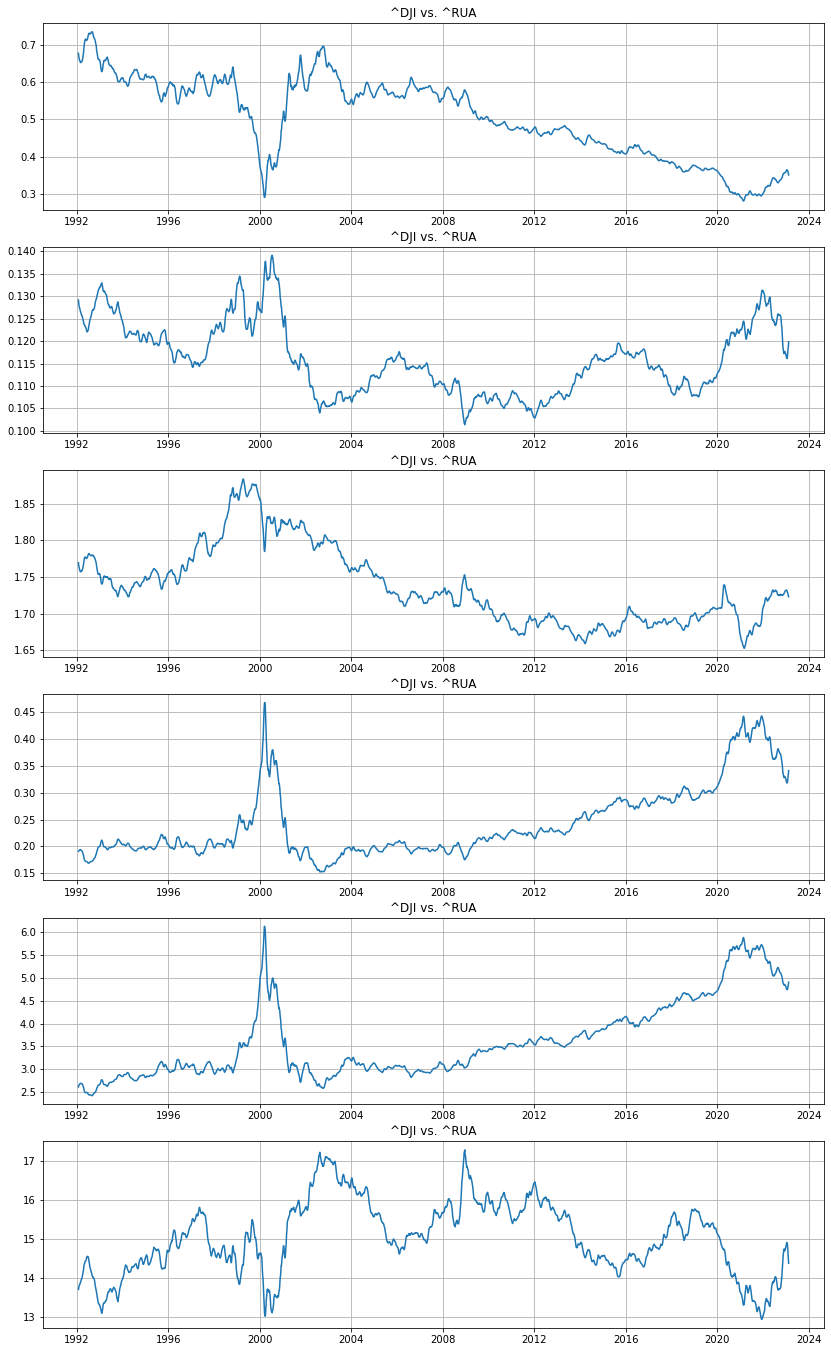

In [13]:
i = 0
fig, axs = plt.subplots(6, 1, figsize=(14, 24))
for tr in trading_ratios_lst:
    axs[i].plot(tr)
    axs[i].grid()
    axs[i].set_title(idx0+' vs. '+idx1)
    i += 1